# Preprocessing and Exploration

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import datetime
import re

//anaconda/envs/nanodegree/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
shots_ds = pd.read_csv('shot_logs.csv')

In [3]:
shots_ds.columns

Index([u'GAME_ID', u'MATCHUP', u'LOCATION', u'W', u'FINAL_MARGIN',
       u'SHOT_NUMBER', u'PERIOD', u'GAME_CLOCK', u'SHOT_CLOCK', u'DRIBBLES',
       u'TOUCH_TIME', u'SHOT_DIST', u'PTS_TYPE', u'SHOT_RESULT',
       u'CLOSEST_DEFENDER', u'CLOSEST_DEFENDER_PLAYER_ID', u'CLOSE_DEF_DIST',
       u'FGM', u'PTS', u'player_name', u'player_id'],
      dtype='object')

In [4]:
shots_ds.dtypes

GAME_ID                         int64
MATCHUP                        object
LOCATION                       object
W                              object
FINAL_MARGIN                    int64
SHOT_NUMBER                     int64
PERIOD                          int64
GAME_CLOCK                     object
SHOT_CLOCK                    float64
DRIBBLES                        int64
TOUCH_TIME                    float64
SHOT_DIST                     float64
PTS_TYPE                        int64
SHOT_RESULT                    object
CLOSEST_DEFENDER               object
CLOSEST_DEFENDER_PLAYER_ID      int64
CLOSE_DEF_DIST                float64
FGM                             int64
PTS                             int64
player_name                    object
player_id                       int64
dtype: object

In [5]:
shots_ds.head()

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,...,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,...,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,...,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,...,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148


In [6]:
pd.isnull(shots_ds).any()

GAME_ID                       False
MATCHUP                       False
LOCATION                      False
W                             False
FINAL_MARGIN                  False
SHOT_NUMBER                   False
PERIOD                        False
GAME_CLOCK                    False
SHOT_CLOCK                     True
DRIBBLES                      False
TOUCH_TIME                    False
SHOT_DIST                     False
PTS_TYPE                      False
SHOT_RESULT                   False
CLOSEST_DEFENDER              False
CLOSEST_DEFENDER_PLAYER_ID    False
CLOSE_DEF_DIST                False
FGM                           False
PTS                           False
player_name                   False
player_id                     False
dtype: bool

In [7]:
shots_ds.shape

(128069, 21)

In [8]:
# The following two columns represent the same thing so we will drop the SHOT_RESULT column
print shots_ds.SHOT_RESULT.unique()
print shots_ds.FGM.unique()

['made' 'missed']
[1 0]


In [9]:
shots_ds.drop('SHOT_RESULT', axis=1, inplace=True)

In [10]:
splits = lambda x: pd.Series([i for i in re.split(' - | @ | vs. ', x)])

In [11]:
res = shots_ds['MATCHUP'].apply(splits)

In [12]:
shots_ds['date'], shots_ds['away'], shots_ds['home'] = res[0], res[1], res[2]

In [13]:
print sorted(shots_ds.away.unique()), sorted(shots_ds.home.unique())
assert len(shots_ds.away) == len(shots_ds.home)

['ATL', 'BKN', 'BOS', 'CHA', 'CHI', 'CLE', 'DAL', 'DEN', 'DET', 'GSW', 'HOU', 'IND', 'LAC', 'LAL', 'MEM', 'MIA', 'MIL', 'MIN', 'NOP', 'NYK', 'OKC', 'ORL', 'PHI', 'PHX', 'POR', 'SAC', 'SAS', 'TOR', 'UTA', 'WAS'] ['ATL', 'BKN', 'BOS', 'CHA', 'CHI', 'CLE', 'DAL', 'DEN', 'DET', 'GSW', 'HOU', 'IND', 'LAC', 'LAL', 'MEM', 'MIA', 'MIL', 'MIN', 'NOP', 'NYK', 'OKC', 'ORL', 'PHI', 'PHX', 'POR', 'SAC', 'SAS', 'TOR', 'UTA', 'WAS']


In [14]:
# Now that we have split up MATCHUP we can drop this column
shots_ds.drop('MATCHUP', axis=1, inplace=True)

# Defense Analysis

Some things to investigate:

- Who did people shoot around the most
- Who had the best/worst shots made % within x distance
- Who had the best/worst shots made by being closest defender
    - Wing vs interior?
- Who had best ratio of minutes played to being closest defender to shot
- Who had the worst ration of minutes played to being closest defender to a shot


In [15]:
# More defenders than shot takers recorded..
print len(shots_ds.player_id.unique()), len(shots_ds.CLOSEST_DEFENDER_PLAYER_ID.unique())

281 474


In [16]:
players_ds = pd.DataFrame(list(set(shots_ds['CLOSEST_DEFENDER_PLAYER_ID'])))

We can see that people shoot around Big Men the most.  This makes sense because a lot of shots are from drives to the hoop and these people are rim protectors.  They have to deal with drives to the hoop by players they aren't defending, in addition to post up moves from the players they are actually defending.  One should note that being the closest defender to a shot may also show the player's ability to get close to shooters (agility).

In [17]:
defender_df = pd.concat([shots_ds['CLOSEST_DEFENDER_PLAYER_ID'], shots_ds['CLOSEST_DEFENDER']], axis=1, keys=['PLAYER_ID', 'PLAYER'])
defender_df = defender_df.drop_duplicates()

In [18]:
t_df = shots_ds.groupby('CLOSEST_DEFENDER_PLAYER_ID').count()[['GAME_ID']]
t_df.reset_index(level=0, inplace=True)
t_df.rename(columns={'CLOSEST_DEFENDER_PLAYER_ID':'PLAYER_ID', 'GAME_ID':'SHOTS_DEFENDED'}, inplace=True)
defender_df = defender_df.merge(t_df, on='PLAYER_ID')

In [19]:
t_df = shots_ds.groupby('CLOSEST_DEFENDER_PLAYER_ID').sum()[['DRIBBLES', 'TOUCH_TIME', 'SHOT_DIST', 'CLOSE_DEF_DIST', 'FGM', 'PTS']]
t_df.reset_index(level=0, inplace=True)
t_df.rename(columns={'CLOSEST_DEFENDER_PLAYER_ID':'PLAYER_ID', 'FGM':'SHOTS_DEFENDED_MADE'}, inplace=True)
defender_df = defender_df.merge(t_df, on='PLAYER_ID')

In [20]:
# Calculate column percentages
defender_df['FG%'] = defender_df['SHOTS_DEFENDED_MADE']/defender_df['SHOTS_DEFENDED']
defender_df['AVG_DRIBBLES'] = defender_df['DRIBBLES']/defender_df['SHOTS_DEFENDED']
defender_df['AVG_SHOT_DIST'] = defender_df['SHOT_DIST']/defender_df['SHOTS_DEFENDED']
defender_df['AVG_CLOSE_DEF_DIST'] = defender_df['CLOSE_DEF_DIST']/defender_df['SHOTS_DEFENDED']
defender_df['AVG_PTS'] = defender_df['PTS']/defender_df['SHOTS_DEFENDED']
defender_df['AVG_TOUCH_TIME'] = defender_df['TOUCH_TIME']/defender_df['SHOTS_DEFENDED']

In [25]:
# We only really care about defenders with a decent number of shots against them
defender_dfs = defender_df[defender_df.SHOTS_DEFENDED > 200]

In [27]:
defender_dfs.columns

Index([u'PLAYER_ID', u'PLAYER', u'SHOTS_DEFENDED', u'DRIBBLES', u'TOUCH_TIME',
       u'SHOT_DIST', u'CLOSE_DEF_DIST', u'SHOTS_DEFENDED_MADE', u'PTS', u'%FG',
       u'AVG_DRIBBLES', u'AVG_SHOT_DIST', u'AVG_CLOSE_DEF_DIST', u'AVG_PTS',
       u'AVG_TOUCH_TIME'],
      dtype='object')

In [55]:
# The worst defenders by average points scored against.. Some pretty big names on here!
defender_dfs.sort_values('AVG_PTS', ascending=False)[:20]

,PLAYER_ID,PLAYER,SHOTS_DEFENDED,DRIBBLES,TOUCH_TIME,SHOT_DIST,CLOSE_DEF_DIST,SHOTS_DEFENDED_MADE,PTS,%FG,AVG_DRIBBLES,AVG_SHOT_DIST,AVG_CLOSE_DEF_DIST,AVG_PTS,AVG_TOUCH_TIME
124,201952,"Teague, Jeff",423,1067,1297.5,7654.5,1888.6,169,399,0.399527,2.522459,18.095745,4.464775,0.943262,3.067376
141,2037,"Crawford, Jamal",267,506,652.1,4811.2,1357.6,122,285,0.456929,1.895131,18.019476,5.084644,1.067416,2.442322
199,2747,"Smith, J.R.",335,410,672.4,5993.6,1736.9,142,340,0.423881,1.223881,17.891343,5.184776,1.014925,2.007164
8,201961,"Ellington, Wayne",319,677,938.2,5664.6,1417.6,132,313,0.413793,2.122257,17.757367,4.443887,0.981191,2.941066
161,203471,"Schroder, Dennis",242,585,718.5,4284.0,1019.5,118,282,0.487603,2.417355,17.702479,4.212810,1.165289,2.969008
361,201945,"Henderson, Gerald",408,766,1065.0,7216.1,1869.8,170,396,0.416667,1.877451,17.686520,4.582843,0.970588,2.610294
266,200757,"Sefolosha, Thabo",234,416,600.5,4086.7,1021.9,92,224,0.393162,1.777778,17.464530,4.367094,0.957265,2.566239
296,2749,"Nelson, Jameer",303,830,970.5,5226.9,1295.0,145,335,0.478548,2.739274,17.250495,4.273927,1.105611,3.202970
318,101145,"Ellis, Monta",563,1079,1503.2,9650.0,2507.1,226,539,0.401421,1.916519,17.140320,4.453108,0.957371,2.669982
387,203917,"Stauskas, Nik",210,342,500.4,3594.9,897.8,93,220,0.442857,1.628571,17.118571,4.275238,1.047619,2.382857


In [53]:
def get_defensive_stats(player_name):
    return defender_dfs[defender_dfs['PLAYER'] == player_name]
get_defensive_stats('Lillard, Damian')

,PLAYER_ID,PLAYER,SHOTS_DEFENDED,DRIBBLES,TOUCH_TIME,SHOT_DIST,CLOSE_DEF_DIST,SHOTS_DEFENDED_MADE,PTS,%FG,AVG_DRIBBLES,AVG_SHOT_DIST,AVG_CLOSE_DEF_DIST,AVG_PTS,AVG_TOUCH_TIME
138,203081,"Lillard, Damian",579,1868,2118.5,9033.1,2343.6,251,545,0.433506,3.226252,15.601209,4.047668,0.941278,3.658895


In [34]:
correlations = defender_dfs[['SHOTS_DEFENDED', 'FG%', 'AVG_DRIBBLES', 'AVG_SHOT_DIST', 'AVG_CLOSE_DEF_DIST', 'AVG_PTS', 'AVG_TOUCH_TIME']].corr()

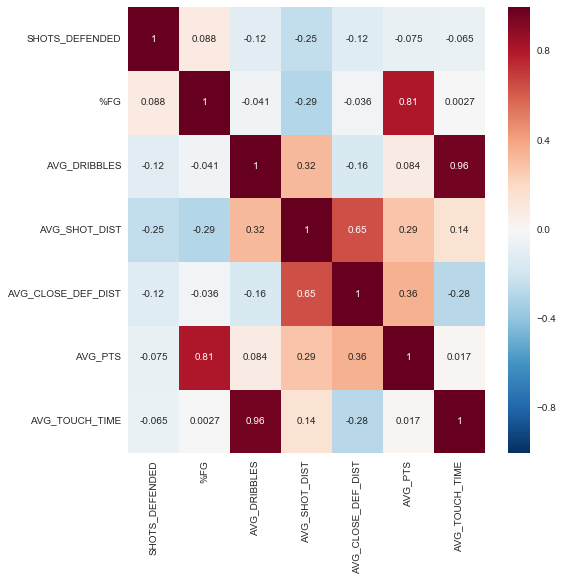

In [38]:
plt.figure(figsize=(8,8))
sns.heatmap(correlations, annot=True)

The above heatmap shows several interesting points.  Some significant insights include:
 - Worse defenders have a slightly higher chance of a shot being taken on them (shots defended versus FG%)
     - This is a broad generalization with a large assumption
 - The further away the shot is, the less chance of it going in (ok this is obvious)
 - The more dribbles, the further away the shot is likely to be from the basket
 - There is no siginificant relation between touch time of the basketball or dribbles and the chance the shot goes in
     - Perhaps this is because a lot of dribbles means not a 3 pt shot, so it evens out a little there
 - More dribbles means a defender was closer to the shot
 - Further away shots have further away defenders
 - The further away the shot, the more points are scored (although FG% goes down)
 - The further away the defender is, the more points scored (although FG% is not correlated with this)
 - The longer the ball is held by an offensive player, the closer the defender gets for the shot
 
While these are mostly broad generalizations, I believe they still offer some insight to the NBA game.

In [56]:
# Offensive Analysis